In [11]:
%matplotlib inline
import xgboost
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
from sklearn.metrics import *
import matplotlib.pylab as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

# Function

In [27]:
def str_to_num(df, train=True):
    '''
    ppl_id : del string and change dtype to num
    activity id : del number and str(act)
    type : del string and change dtype to num
    bool : 0, 1
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    train : bool
        train :True, test : False
    --------
    '''
    col_list = list(df.columns)
    col_list.remove('date_x')
    col_list.remove('date_y')
    if train:
        col_list.remove('outcome')
        
    for col in col_list[:col_list.index('char_9_y')+1]:
        if col == 'activity_id':
            df[col] = df[col].apply(lambda x: x.split('_')[0])
            df.replace('act', '', regex=True, inplace = True)
        elif col == 'people_id':
            df[col] = df[col].apply(lambda x: x.split('_')[1])
        else :
            df[col][df[col].isnull()==False] = df[col][df[col].isnull()==False].apply(lambda x: x.split(' ')[1])
        df[col][df[col].isnull()==False] = pd.to_numeric(df[col][df[col].isnull()==False]).astype(int)
        
    for col in col_list[col_list.index('char_10_y'):col_list.index('char_38')+1]:
        df[col] = df[col].replace({True:1, False:0})
        
    return df

In [3]:
def date_modify(df):
    '''
    add week_x, week_y, and Past_days
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    df.insert(loc=list(df).index('date_x')+1 ,column='week_x', value=df['date_x'].dt.weekday)
    df.insert(loc=list(df).index('date_y')+1 ,column='week_y', value=df['date_y'].dt.weekday)
    df.insert(loc=list(df).index('week_x')+1 ,column='Past_days', value=(df.date_x - df.date_y).astype('timedelta64[D]'))
    return df

In [4]:
def add_bool_sum(df):
    '''
    add colum 'bool_sum' : sum of char_10_y ~ char_37
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    temp = df.copy()
    temp['bool_sum'] = temp.iloc[:,list(temp).index('char_10_y'):list(temp).index('char_37')].sum(axis=1)
    return temp

In [5]:
def num_to_cat(df, columns):
    '''
    change dtype(num to str)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    temp[columns] = pd.DataFrame(temp[columns], dtype='str')
    return temp

In [6]:
def one_hot_encoder(df, columns):
    '''
    columns encoding(one-hot-encoding)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    for col in columns:
        for i in list(pd.get_dummies(temp[col]))[-1::-1]:    
            temp.insert(loc=list(temp).index(col)+1 ,column=col+str(i), value=pd.get_dummies(temp[col]).loc[:,i])
        temp = temp.drop([col], axis=1)
    return temp

In [7]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

# 강사님 함수
def draw_decision_tree(model, feature_names):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

# data load & 전처리

### train data

In [29]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [30]:
str_to_num(df_merge, train=True)
date_modify(df_merge)
df_merge = add_bool_sum(df_merge)
del df_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
df = df_merge.copy()

In [45]:
idx = df.char_1_x[df.char_1_x.isnull()==False].index

In [57]:
df.char_1_x.loc[idx]

52          3
105        36
106        24
107         2
108         2
124         5
125         5
126         3
127         5
128         5
129         2
130         2
186        12
187        12
206        36
219         3
220         3
231         5
232        23
243        12
250         2
251         3
252         3
253         3
254         2
           ..
2196931    12
2197021     1
2197022     2
2197023     2
2197024     2
2197025     2
2197026     2
2197027     2
2197028     2
2197029     2
2197030     2
2197031     2
2197032     2
2197035     5
2197144    10
2197157     6
2197158     3
2197163     7
2197192     3
2197195    12
2197196    12
2197220    12
2197227    30
2197233    12
2197245     5
Name: char_1_x, Length: 157615, dtype: object

In [60]:
for col in list(df):
    if df[col].dtypes == object:
        idx = df[col][df[col].isnull()==False].index
        df[col].loc[idx] = df[col].loc[idx].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [61]:
df.dtypes

people_id                     int64
activity_id                   int32
date_x               datetime64[ns]
week_x                        int64
Past_days                   float64
activity_category             int32
char_1_x                     object
char_2_x                     object
char_3_x                     object
char_4_x                     object
char_5_x                     object
char_6_x                     object
char_7_x                     object
char_8_x                     object
char_9_x                     object
char_10_x                    object
outcome                       int64
char_1_y                      int32
group_1                       int32
char_2_y                      int32
date_y               datetime64[ns]
week_y                        int64
char_3_y                      int32
char_4_y                      int32
char_5_y                      int32
                          ...      
char_15                       int64
char_16                     

In [21]:
df.char_1_x[df.char_1_x.isnull()==False].astype(int).dtypes

dtype('int32')

### test data

In [40]:
df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')

In [41]:
# submissin 만들때 필요함
df_test_act_id = df_merge_test.activity_id.copy()

In [42]:
str_to_num(df_merge_test, train=False)
date_modify(df_merge_test)
df_merge_test = add_bool_sum(df_merge_test)
del df_test, df_peopleo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### save data

In [12]:
# df_merge.to_csv("train_merge.csv")
# df_merge_test.to_csv("test_merge.csv")

In [13]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])
# df_merge_test = pd.read_csv('./test_merge.csv', parse_dates=['date_x', 'date_y'])

# EDA

In [14]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



In [15]:
df_merge.describe()

,people_id,week_x,Past_days,outcome,week_y,char_38,bool_sum
count,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06
mean,2.023863e+05,3.231972e+00,2.593235e+02,4.439544e-01,3.142312e+00,4.998051e+01,6.741608e+00
std,1.159728e+05,1.558017e+00,2.748091e+02,4.968491e-01,1.528937e+00,3.608557e+01,9.439904e+00
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.032760e+05,2.000000e+00,1.700000e+01,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,2.041670e+05,3.000000e+00,1.710000e+02,0.000000e+00,3.000000e+00,5.900000e+01,0.000000e+00
75%,2.997910e+05,4.000000e+00,4.230000e+02,1.000000e+00,4.000000e+00,8.200000e+01,1.400000e+01
max,3.982380e+05,6.000000e+00,1.197000e+03,1.000000e+00,6.000000e+00,1.000000e+02,2.700000e+01


In [16]:
df_merge[['date_x', 'date_y']].describe()

,date_x,date_y
count,2197291,2197291
unique,411,1196
top,2022-09-30 00:00:00,2022-03-02 00:00:00
freq,48174,55371
first,2022-07-17 00:00:00,2020-05-18 00:00:00
last,2023-08-31 00:00:00,2023-08-31 00:00:00


In [17]:
pd.DataFrame(df_merge.people_id, dtype='object').describe()

,people_id
count,2197291
unique,151295
top,294918
freq,55103


In [18]:
df_merge.people_id.unique()

array([   100, 100002, 100003, ...,   9999,  99992,  99994], dtype=int64)

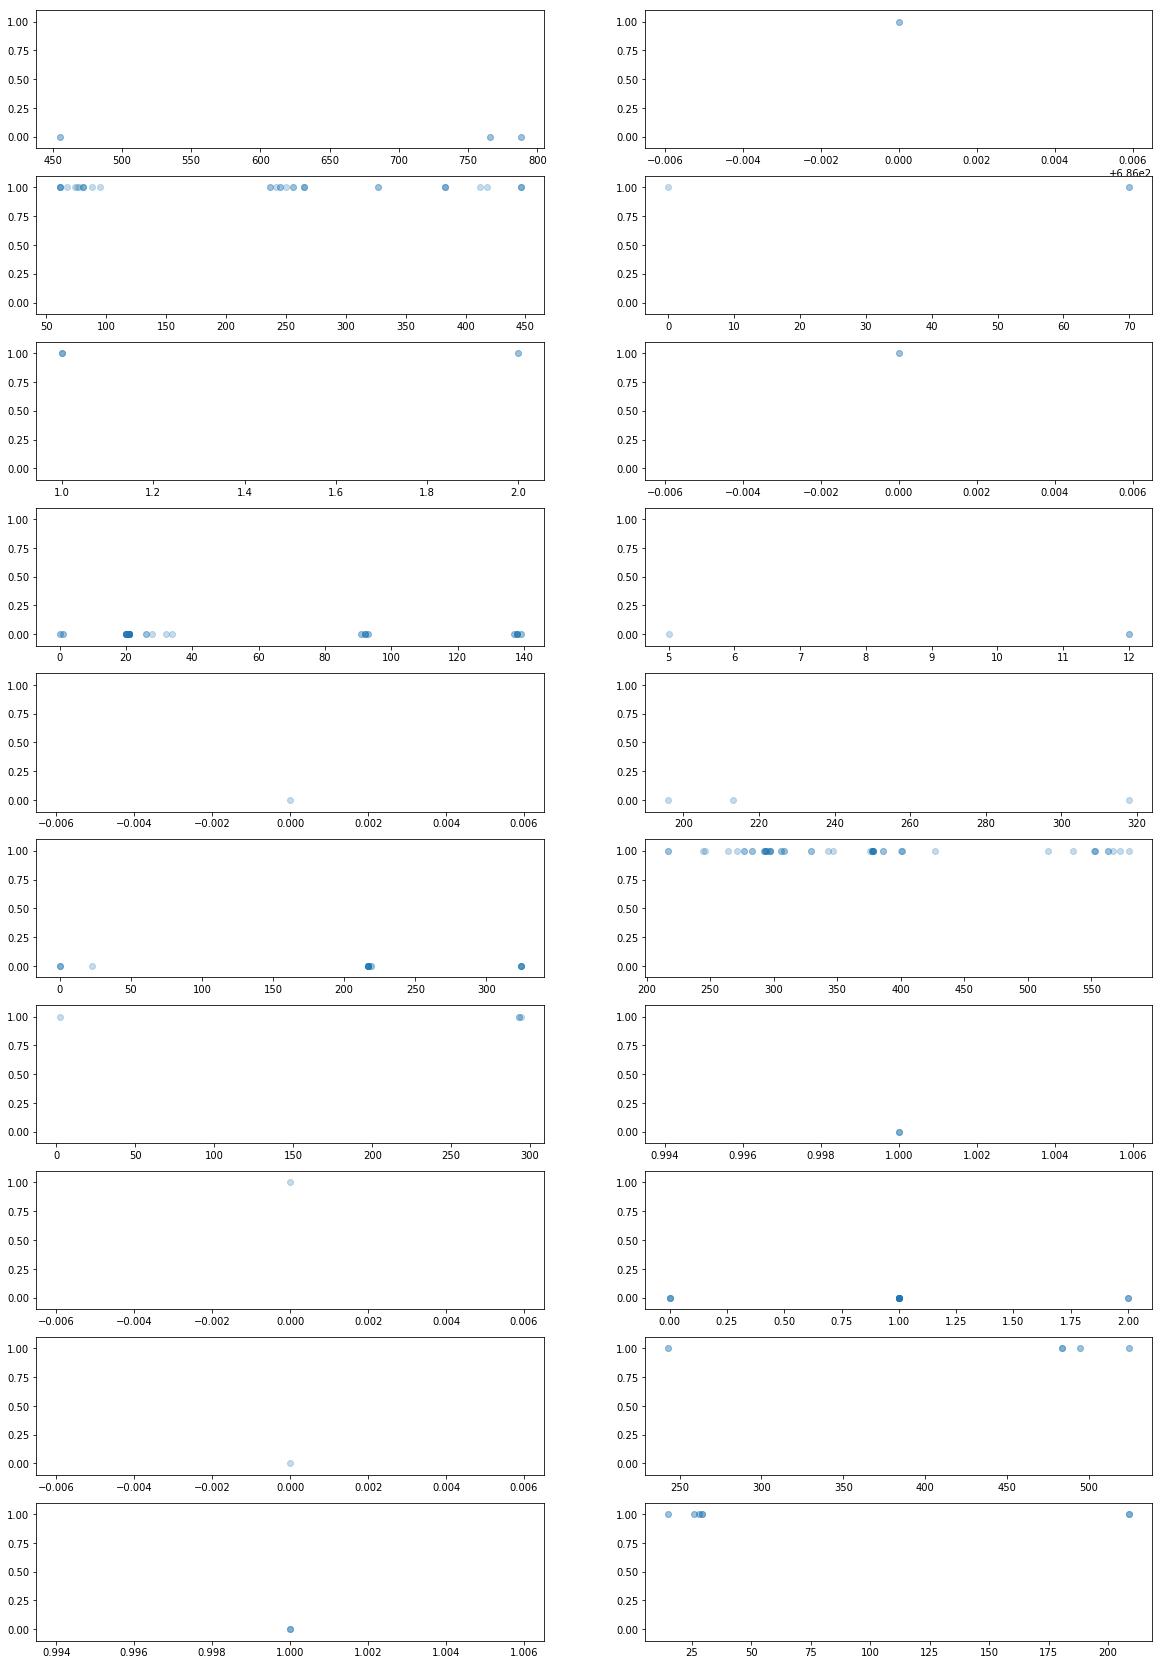

In [19]:
# ppl 별 구매 경향
plt.figure(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [20]:
df_merge.people_id.value_counts().head()

294918    55103
370270    53668
105739    45936
54699     23969
64887      7052
Name: people_id, dtype: int64

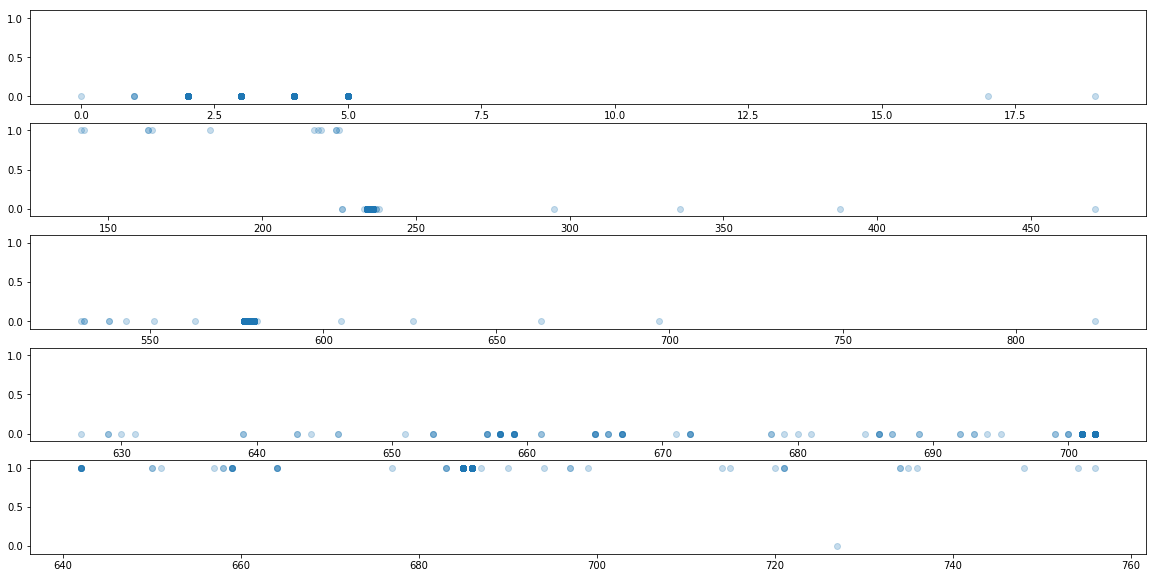

In [21]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, ppl in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

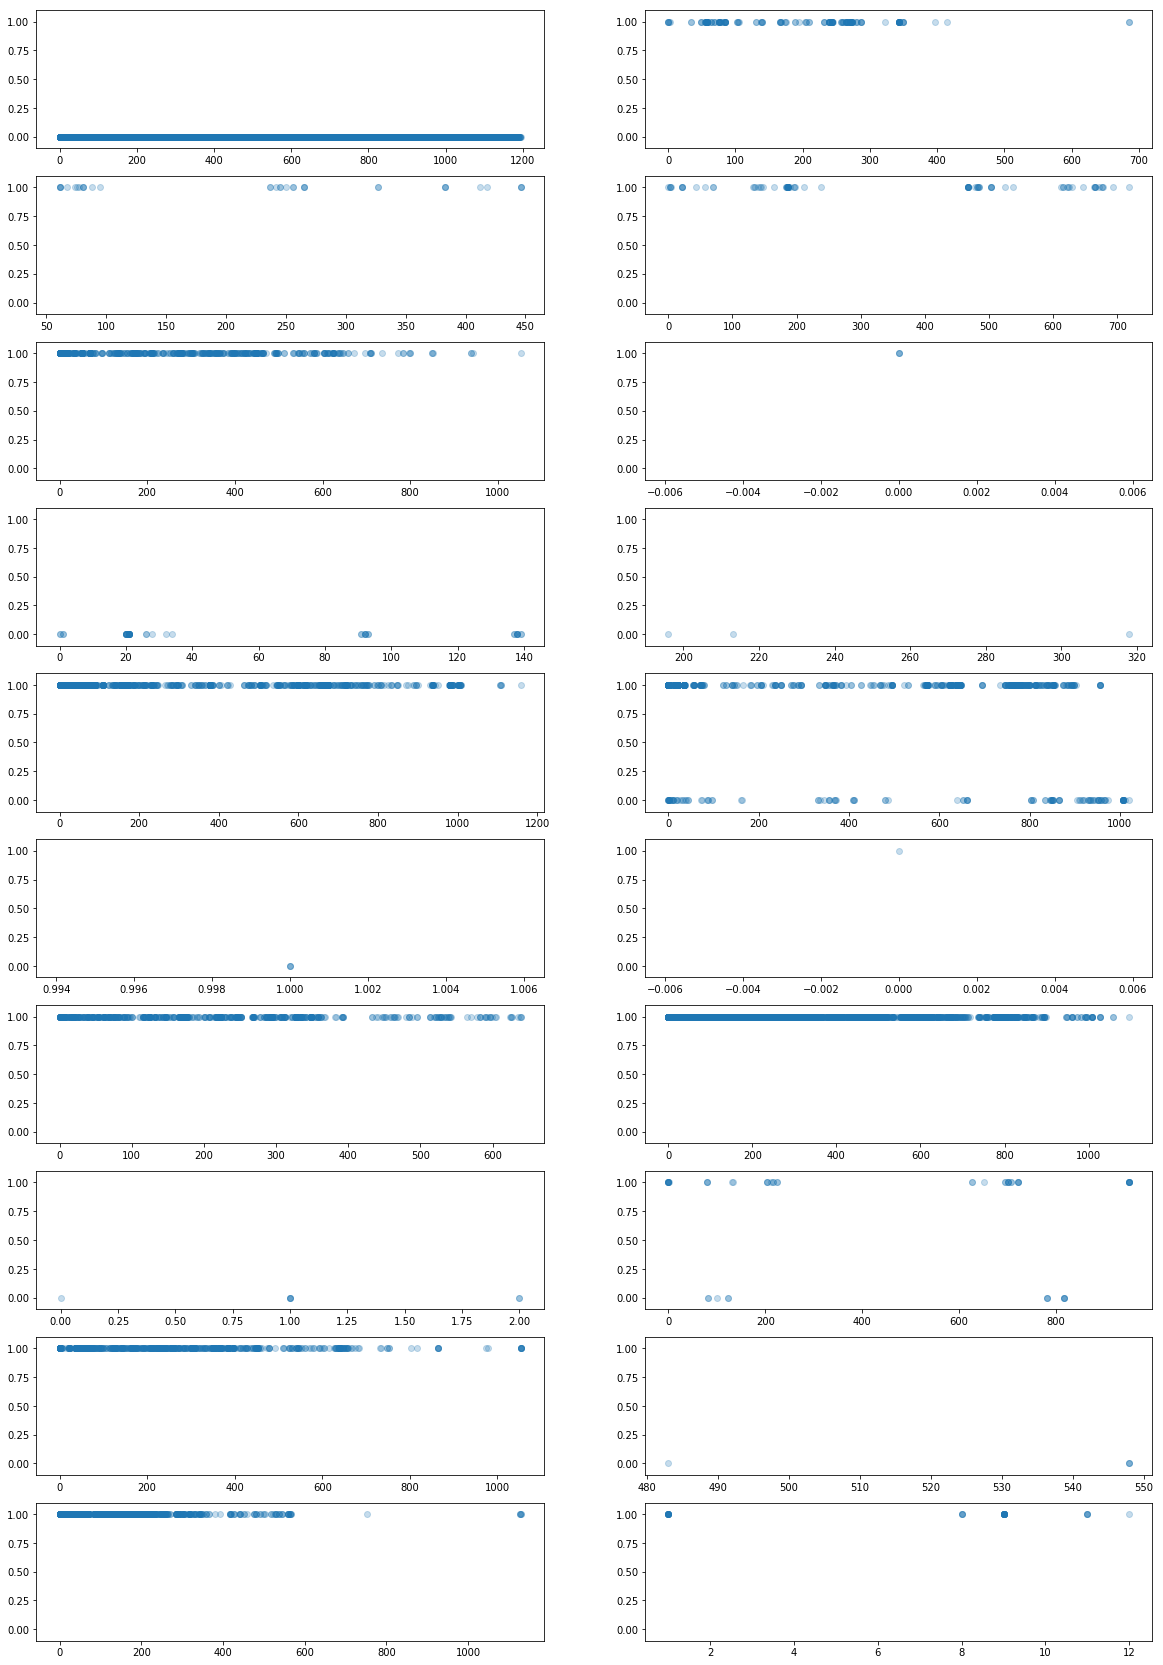

In [22]:
# group 별 구매 경향
plt.figure(figsize=(20,30))
for i, group in enumerate(df_merge.group_1.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

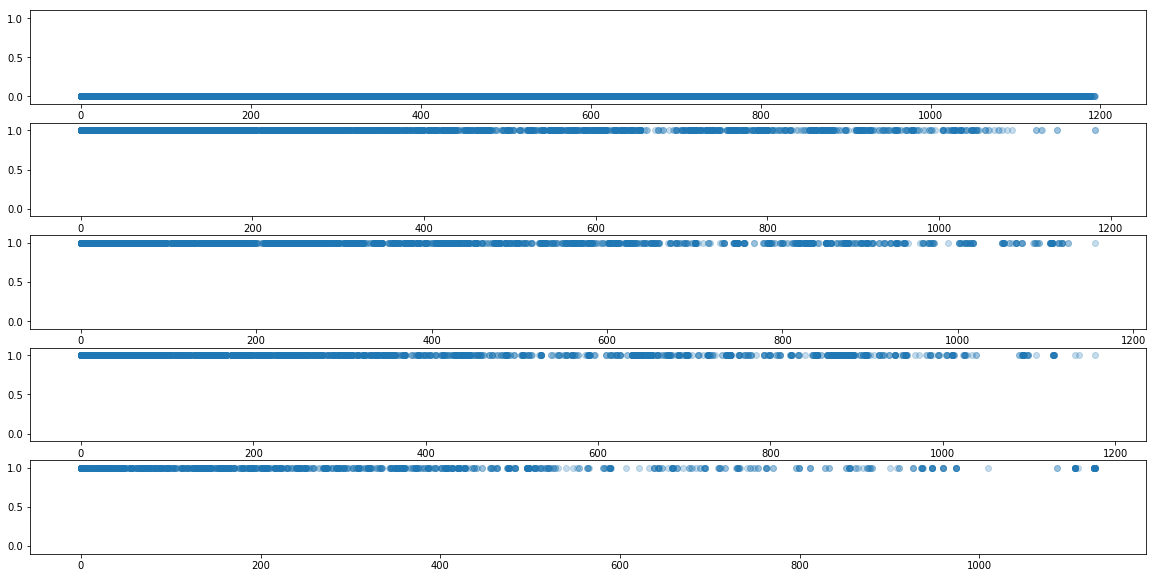

In [23]:
# group 별 구매 경향 top 5

plt.figure(figsize=(20,10))
for i, group in enumerate([17304, 667, 8386, 9280,450]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

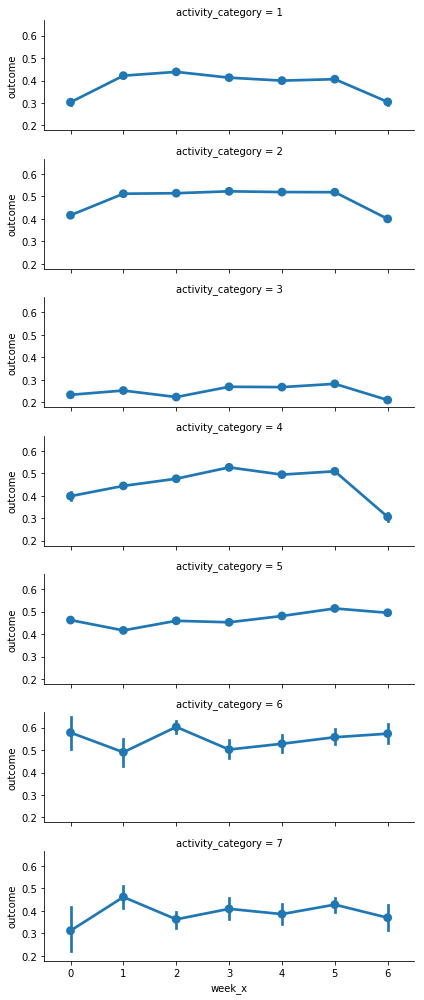

In [24]:
sns.factorplot(x="week_x", y="outcome", row="activity_category", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

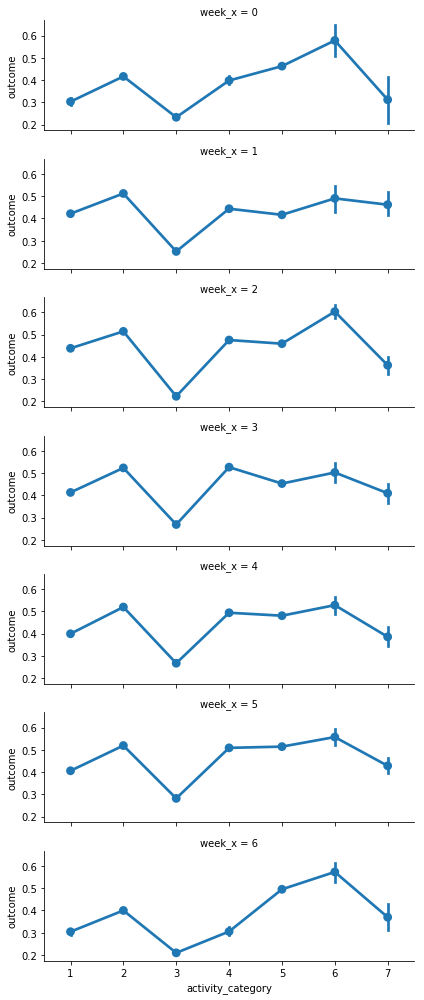

In [25]:
sns.factorplot(x="activity_category", y="outcome", row="week_x", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

#### sample

In [26]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()
df_sample = add_bool_sum(df_sample)

In [27]:
df_sample2 = df_merge.sample(frac = 0.1, random_state=1).copy()
df_sample2 = add_bool_sum(df_sample2)

In [28]:
df_sample.groupby(['activity_id', 'activity_category']).count()

people_id  date_x  week_x  Past_days  char_1_x  \
activity_id activity_category                                                   
1           1                      15813   15813   15813      15813     15813   
2           2                      90498   90498   90498      90498         0   
            3                      42804   42804   42804      42804         0   
            4                      20891   20891   20891      20891         0   
            5                      48968   48968   48968      48968         0   
            6                        429     429     429        429         0   
            7                        326     326     326        326         0   

                               char_2_x  char_3_x  char_4_x  char_5_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_6_x  char_7_x  char_8_x  char_9_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_10_x  outcome  char_1_y  group_1  \
activity_id activity_category                                          
1           1                          0    15813     15813    15813   
2           2                      90498    90498     90498    90498   
            3                      42804    42804     42804    42804   
            4                      20891    20891     20891    20891   
            5                      48968    48968     48968    48968   
            6                        429      429       429      429   
            7                        326      326       326      326   

                               char_2_y  date_y  week_y  char_3_y  char_4_y  \
activity_id activity_category                                                 
1           1                     15813   15813   15813     15813     15813   
2           2                     90498   90498   90498     90498     90498   
            3                     42804   42804   42804     42804     42804   
            4                     20891   20891   20891     20891     20891   
            5                     48968   48968   48968     48968     48968   
            6                       429     429     429       429       429   
            7                       326     326     326       326       326   

                               char_5_y  char_6_y  char_7_y  char_8_y  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                     90498     90498     90498     90498   
            3                     42804     42804     42804     42804   
            4                     20891     20891     20891     20891   
            5                     48968     48968     48968     48968   
            6                       429       429       429       429   
            7                       326 

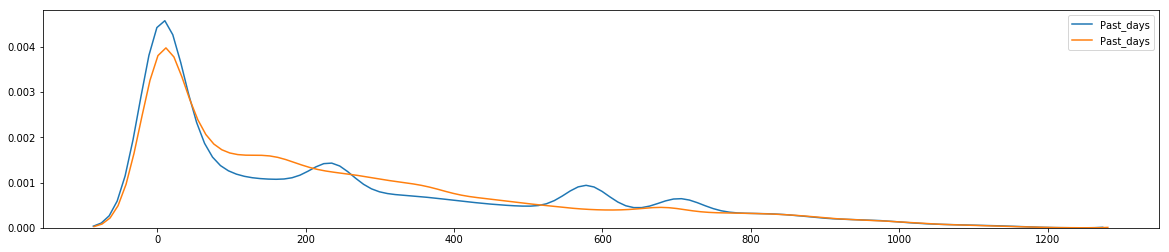

In [29]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['Past_days'])
sns.kdeplot(df_sample[df_sample.outcome==1]['Past_days'])
plt.show()

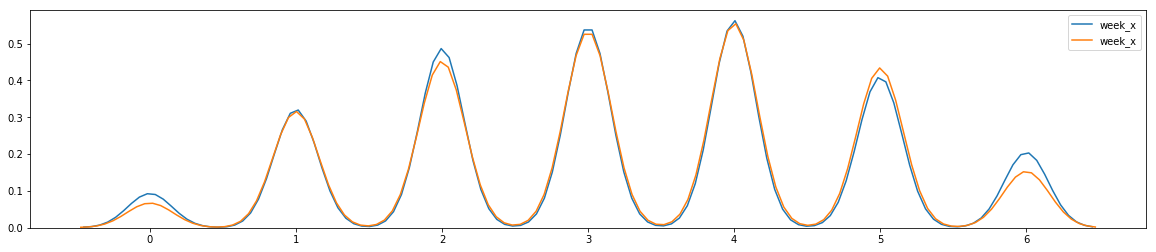

In [30]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['week_x'])
sns.kdeplot(df_sample[df_sample.outcome==1]['week_x'])
plt.show()

#### char_1_x ~ char_9_x

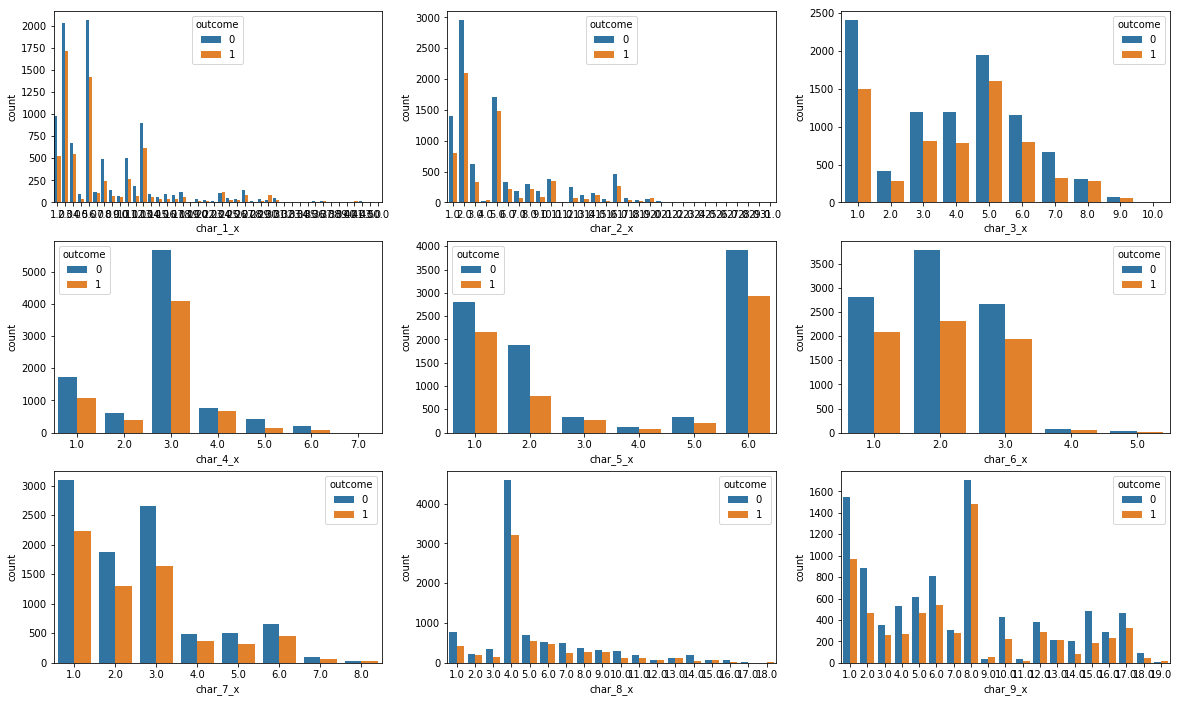

In [31]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_1_x'):list(df_sample).index('char_9_x')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

<function matplotlib.pyplot.show>

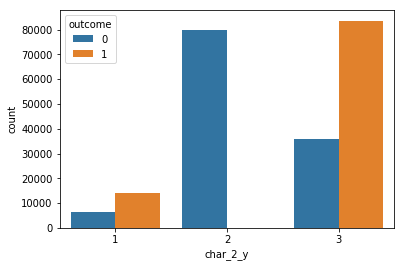

In [32]:
sns.countplot('char_2_y', hue='outcome', data=df_sample)
plt.show

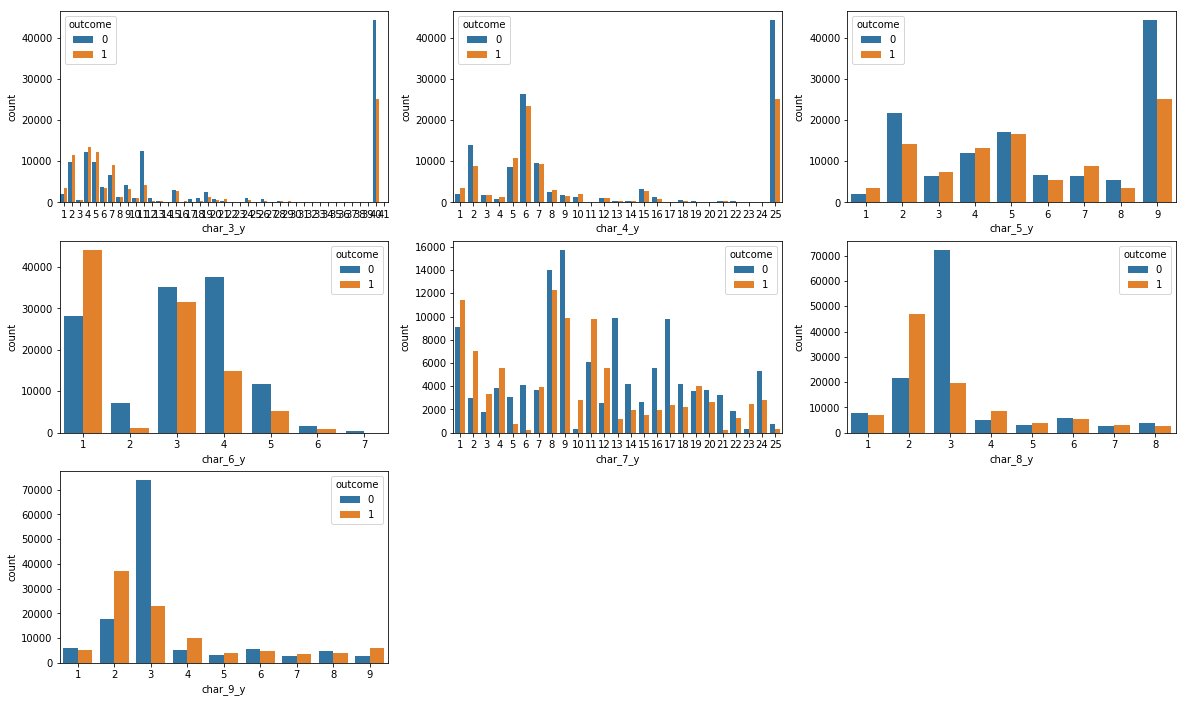

In [33]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_3_y'):list(df_sample).index('char_9_y')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

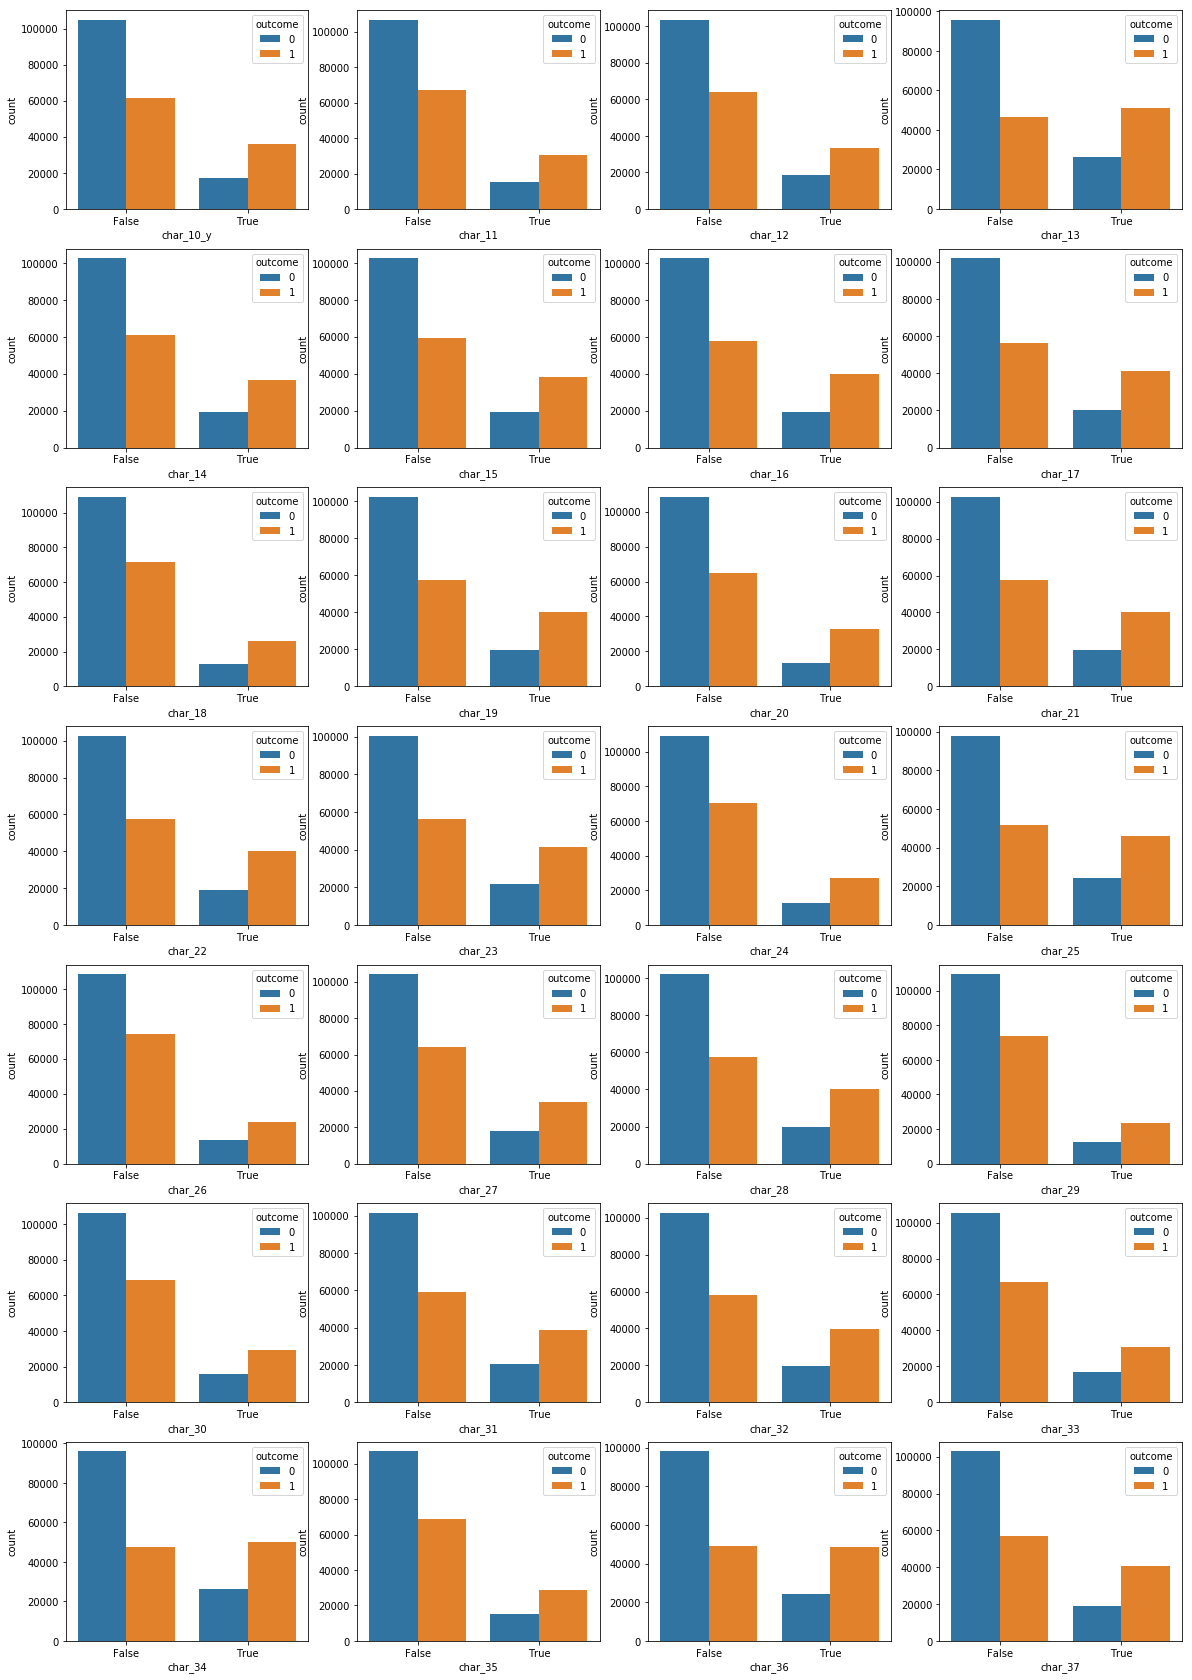

In [34]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_10_y'):list(df_sample).index('char_37')+1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

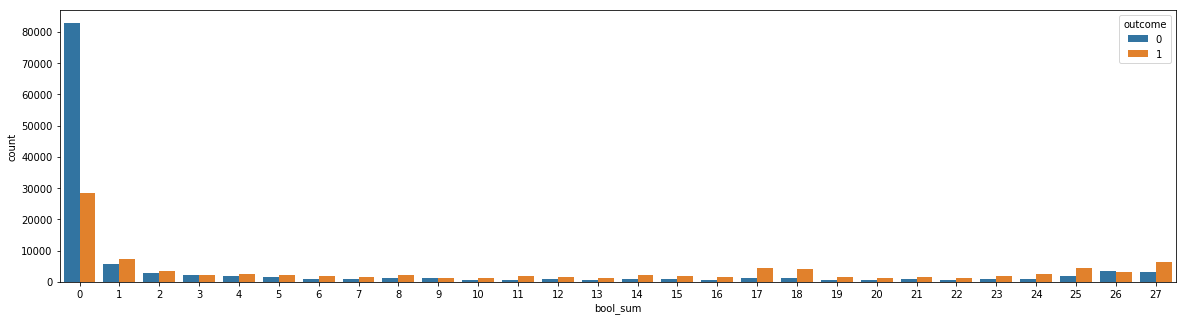

In [35]:
plt.figure(figsize=(20,5))
sns.countplot('bool_sum', hue='outcome', data=df_sample)
plt.show()

#### char_38

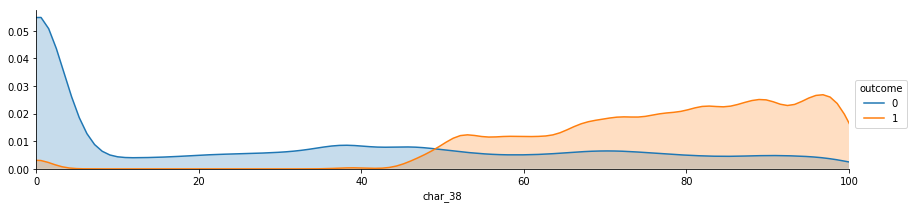

In [36]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

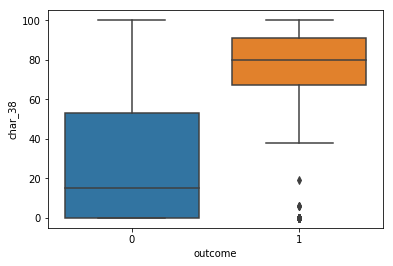

In [37]:
sns.boxplot(x="outcome", y="char_38", data=df_sample)
plt.show()

In [ ]:
del df_sample, df_sample2

# feature selection

In [42]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_merge)
model2 = sm.OLS.from_formula("outcome ~ bool_sum", data=df_merge)
model3 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + char_29 + \
                            char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37 + bool_sum", data=df_merge)
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()

sm.stats.anova_lm(result1, result2, result3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2197262.0,468586.705335,0.0,NaN,NaN,NaN
1,2197289.0,488060.609954,-27.0,-19473.904619,3382.053629,NaN
2,2197261.0,468587.211536,28.0,19473.398418,3261.181226,0.0


In [43]:
sm.stats.anova_lm(result1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
char_10_y,1.0,39255.800197,39255.800197,184075.384704,0.000000e+00
char_11,1.0,3274.086030,3274.086030,15352.601209,0.000000e+00
char_12,1.0,1346.035216,1346.035216,6311.728432,0.000000e+00
char_13,1.0,14478.788745,14478.788745,67892.861561,0.000000e+00
char_14,1.0,637.944548,637.944548,2991.402227,0.000000e+00
char_15,1.0,323.795202,323.795202,1518.316428,0.000000e+00
char_16,1.0,394.985645,394.985645,1852.137371,0.000000e+00
char_17,1.0,516.004010,516.004010,2419.607705,0.000000e+00
char_18,1.0,33.176989,33.176989,155.571077,1.053437e-35
char_19,1.0,11.868689,11.868689,55.653777,8.645827e-14


In [44]:
sm.stats.anova_lm(result2)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
bool_sum,1.0,54360.208053,54360.208053,244734.12678,0.0
Residual,2197289.0,488060.609954,0.222119,NaN,NaN


In [45]:
sm.stats.anova_lm(result3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
char_10_y,1.0,39255.800197,39255.800197,184075.102078,0.000000e+00
char_11,1.0,3274.086030,3274.086030,15352.577637,0.000000e+00
char_12,1.0,1346.035216,1346.035216,6311.718741,0.000000e+00
char_13,1.0,14478.788745,14478.788745,67892.757319,0.000000e+00
char_14,1.0,637.944548,637.944548,2991.397635,0.000000e+00
char_15,1.0,323.795202,323.795202,1518.314097,0.000000e+00
char_16,1.0,394.985645,394.985645,1852.134527,0.000000e+00
char_17,1.0,516.004010,516.004010,2419.603990,0.000000e+00
char_18,1.0,33.176989,33.176989,155.570838,1.053564e-35
char_19,1.0,11.868689,11.868689,55.653691,8.646203e-14


# modeling

#### fillna(0)

In [ ]:
df_merge.fillna(0, inplace=True)
df_merge_test.fillna(0, inplace=True)

#### columns

In [ ]:
a = list(df_merge)
a.remove('date_x')
a.remove('date_y')
a.remove('bool_sum')
a.remove('outcome')
print(a)

In [ ]:
b = list(df_merge)
b.remove('date_x')
b.remove('date_y')
b = b[:27]
b.append('bool_sum')
b.remove('outcome')
print(b)

## 로지스틱 회귀분석

In [49]:
logit_mod = sm.Logit.from_formula("outcome ~ Past_days + char_38 + bool_sum", data=df_merge)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              2197291
Model:                          Logit   Df Residuals:                  2197287
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Nov 2017   Pseudo R-squ.:                  0.4091
Time:                        16:23:39   Log-Likelihood:            -8.9178e+05
converged:                       True   LL-Null:                   -1.5092e+06
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6309      0.006   -636.925      0.000      -3.642      -3.620
Past_days     -0.0001   6.88e-06    -19.336      0.000      -0.000      -0.000
char_38        0.0625    8.5e-05    735.299      0.0

## 나이브 베이즈

+ 베르누이 분포 나이브 베이즈 모형

In [50]:
# clf_bern = BernoulliNB().fit(X, y)

In [51]:
# print(classification_report(df_sample2.outcome, clf_bern.predict(df_sample2[df_sample2.columns[-30:-2]])))

+ 가우시안 정규 분포 나이브 베이즈 모형

In [52]:
clf_norm = GaussianNB().fit(df_merge[a], df_merge.outcome)

In [53]:
cvs = cross_val_score(clf_norm, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10)

In [54]:
cvs.mean()

0.88364266041326789

In [55]:
print(classification_report(df_merge.outcome, clf_norm.predict(df_merge[a])))

             precision    recall  f1-score   support

          0       0.89      0.77      0.82   1221794
          1       0.75      0.88      0.81    975497

avg / total       0.83      0.82      0.82   2197291



## 의사 결정 나무

In [99]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10).fit(df_merge[a], df_merge.outcome)

In [57]:
cross_val_score(tree, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.89161415378857589

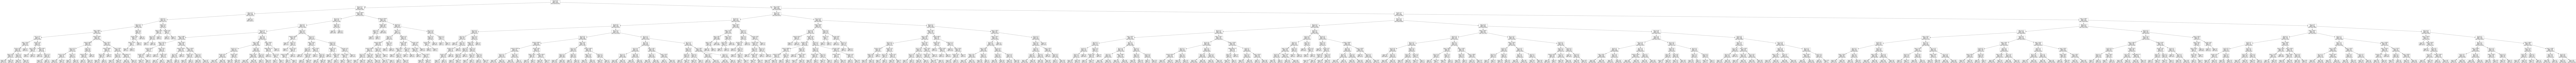

In [100]:
draw_decision_tree(tree, a)

In [59]:
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(df_merge[b], df_merge.outcome)

In [68]:
cross_val_score(tree2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.89106210027402533

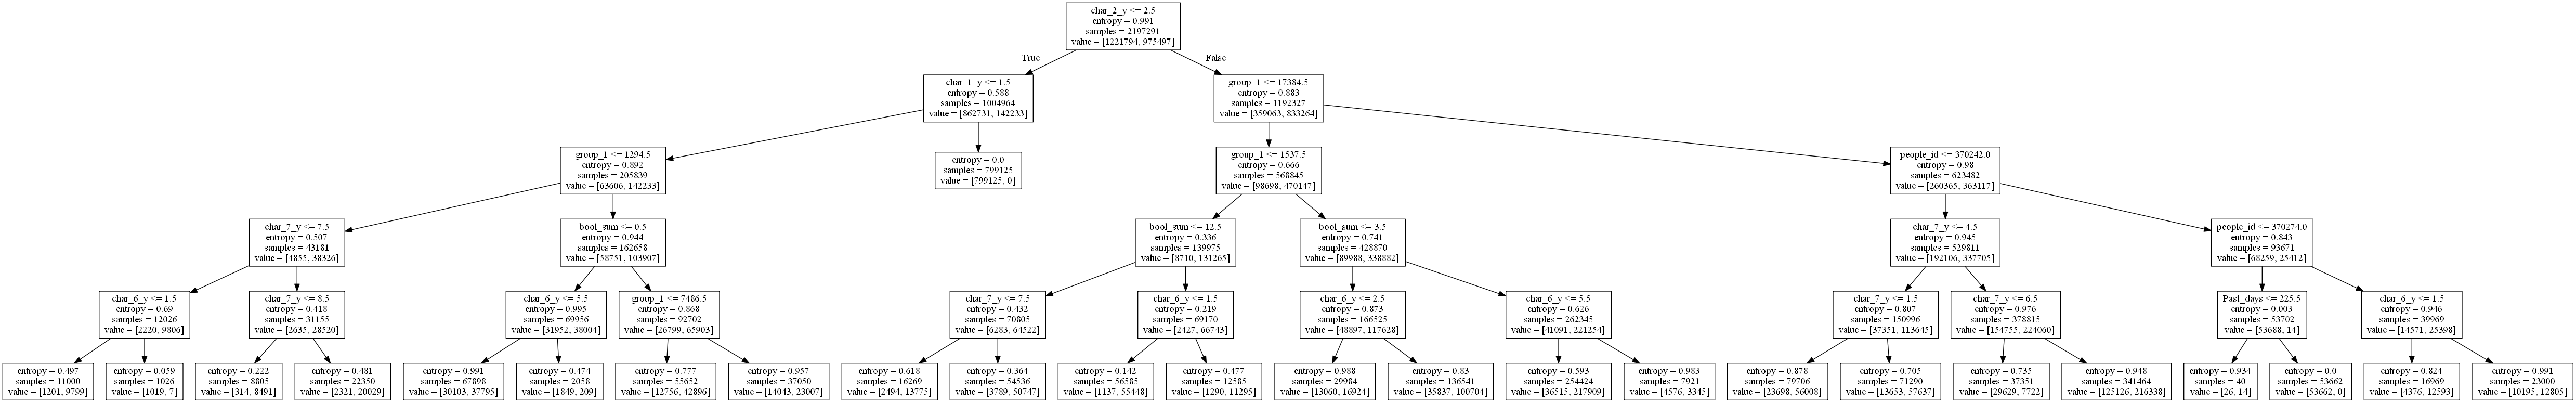

In [61]:
draw_decision_tree(tree2, b)

In [62]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree.csv")

In [63]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree_b.csv")

## 랜덤 포레스트

+ RandomForestClassifier

In [64]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [65]:
cross_val_score(rfc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.90958100478912984

In [70]:
rfc2 = RandomForestClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [71]:
cross_val_score(rfc2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.89779557612738825

In [97]:
# # rfc = RandomForestClassifier(n_estimators=30).fit(df_merge[a], df_merge.outcome) 0.88
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc.csv")

In [98]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc_b.csv")

+ ExtraTreesClassifier

In [72]:
efc = ExtraTreesClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [73]:
cross_val_score(efc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.89220513602836193

In [74]:
efc2 = ExtraTreesClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [75]:
cross_val_score(efc2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.8848930811347282

In [92]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc.csv")

In [94]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc_b.csv")

# xgboost

In [54]:
df_merge2 = one_hot_encoder(df_merge, ['activity_id', 'activity_category'])

In [55]:
a2 = list(df_merge2)
a2.remove('date_x')
a2.remove('date_y')
a2.remove('bool_sum')
a2.remove('outcome')
print(a2)

['people_id', 'activity_id1', 'activity_id2', 'week_x', 'Past_days', 'activity_category1', 'activity_category2', 'activity_category3', 'activity_category4', 'activity_category5', 'activity_category6', 'activity_category7', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'group_1', 'char_2_y', 'week_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


In [56]:
b2 = list(df_merge2)
b2.remove('date_x')
b2.remove('date_y')
b2 = b2[:34]
b2.append('bool_sum')
b2.remove('outcome')
print(b2)

['people_id', 'activity_id1', 'activity_id2', 'week_x', 'Past_days', 'activity_category1', 'activity_category2', 'activity_category3', 'activity_category4', 'activity_category5', 'activity_category6', 'activity_category7', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'group_1', 'char_2_y', 'week_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'bool_sum']


In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [77]:
cross_val_score(xgb, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.90486137823447232

In [78]:
xgb2 = xgboost.XGBClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [79]:
cross_val_score(xgb2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.91019585809432857

In [58]:
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=5).fit(df_merge2[a2], df_merge2.outcome)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields char_1_x, char_2_x, char_3_x, char_4_x, char_5_x, char_6_x, char_7_x, char_8_x, char_9_x, char_10_x, char_1_y, group_1, char_2_y, char_3_y, char_4_y, char_5_y, char_6_y, char_7_y, char_8_y, char_9_y

In [ ]:
cross_val_score(xgb, df_merge2[a2], df_merge2.outcome, scoring="roc_auc", cv=10).mean()

In [95]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb.csv")

In [96]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb_b.csv")